<a href="https://colab.research.google.com/github/rohskopf/FitSNAP/blob/custom-networks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

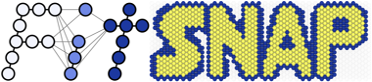

# The FitSNAP-LAMMPS ecosystem for constructing & deconstructing potentials

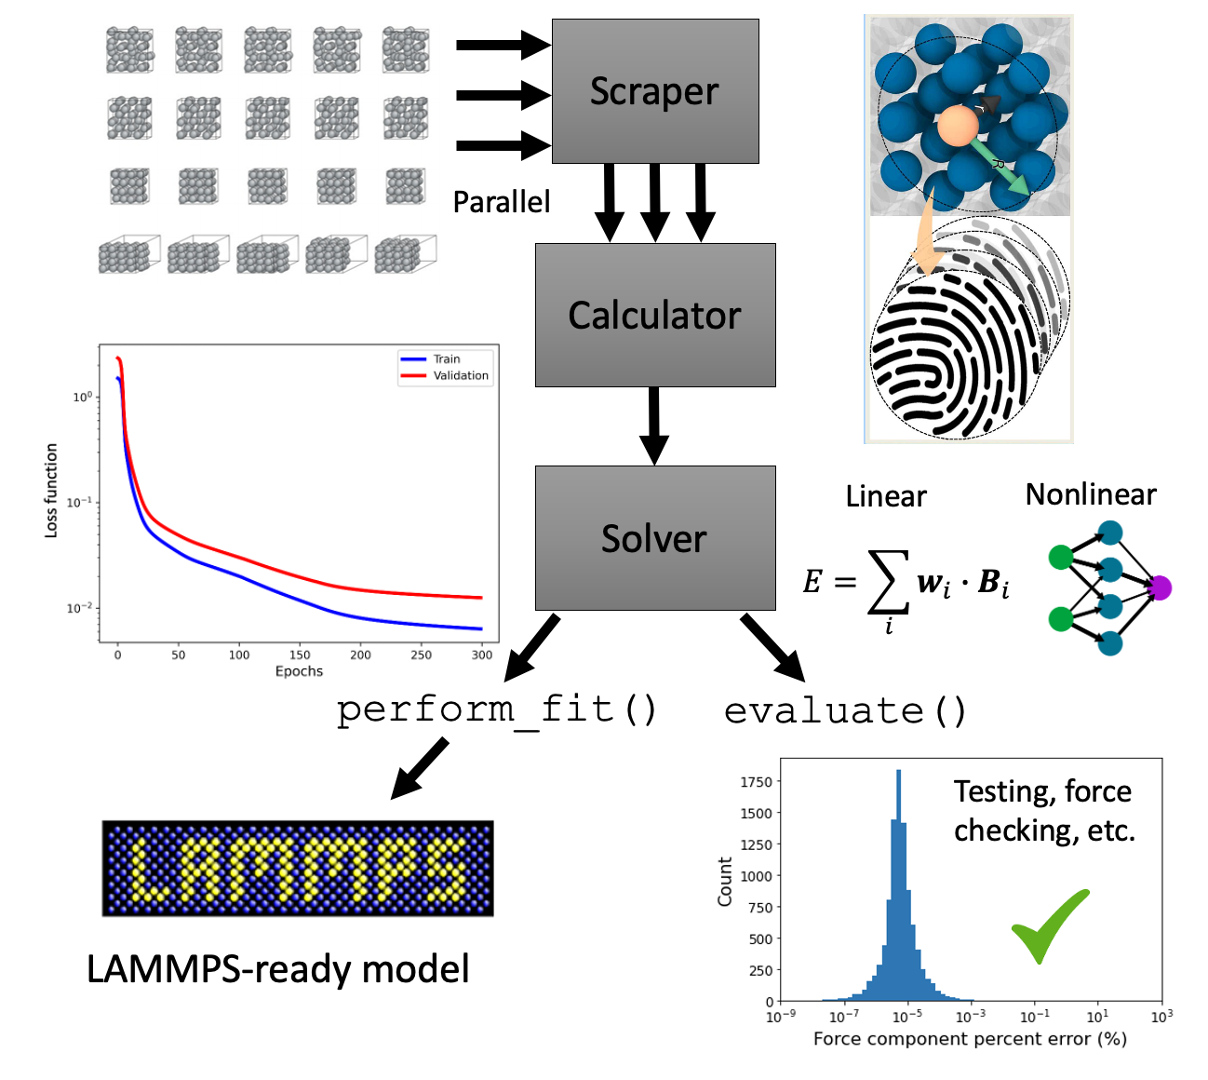


*   We will keep this Colab notebook updated as the code changes. Please refer to it for future use.
*   You can modify the setup procedures here for your own machine; hardest part is properly installing LAMMPS with Python.

# Setup environment

In [ ]:
!which python
!python --version

/usr/local/bin/python
Python 3.7.14


In [ ]:
!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.7-venv
!pip install --upgrade pip
!pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn
%cd /content
!rm -rf lammps
!git clone https://github.com/lammps/lammps.git lammps
%cd /content/lammps
!rm -rf build
!mkdir build
%cd build
!cmake ../cmake -DLAMMPS_EXCEPTIONS=yes \
               -DBUILD_SHARED_LIBS=yes \
               -DMLIAP_ENABLE_PYTHON=yes \
               -DPKG_PYTHON=yes \
               -DPKG_ML-SNAP=yes \
               -DPKG_ML-IAP=yes \
               -DPKG_ML-PACE=yes \
               -DPKG_SPIN=yes \
               -DPYTHON_EXECUTABLE:FILEPATH=`which python`
!make -j 2
!make install-python

Check if Python-LAMMPS is working:

In [2]:
import lammps
lmp = lammps.lammps()
print(lmp)

If no errors, we're good to!

# Get FitSNAP

In [ ]:
%cd /content
!rm -rf FitSNAP
!git clone -b custom-networks https://github.com/rohskopf/FitSNAP #https://github.com/FitSNAP/FitSNAP
# Set environment variables
!$PYTHONPATH
%env PYTHONPATH=/env/python:/bin/bash:/content/FitSNAP
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
!cp -r FitSNAP/fitsnap3lib /usr/lib/python3.7/fitsnap3lib

### Stay updated with the newest version

In [4]:
%cd /content/FitSNAP
!git fetch
!git pull
#!git reset --hard origin/custom-networks
#!rm -rf /usr/lib/python3.7/fitsnap3lib
#!cp -rf fitsnap3lib /usr/lib/python3.7/fitsnap3lib

/content/FitSNAP
Already up to date.


# Linear SNAP for tantalum



*   We start with running FitSNAP as an executable. 
*   The general command is `mpirun -np P python -m fitsnap3 input.in`
*   We will do serial execution in this tutorial because `mpirun` is buggy on Colab.



In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014
!python -m fitsnap3 Ta-example.in --overwrite

Look at the output

In [6]:
!ls

20May21_Standard      FitSNAP.df  Ta-example.in		Ta_pot.snapparam
anl		      JSON	  Ta-example-nodump.in	Test_Set_Example
compare_snapcoeff.py  log.lammps  Ta_metrics.md		Truth-Ref.npy
Descriptors.npy       README.md   Ta_pot.snapcoeff	Weights.npy


Linear models output a Pandas dataframe `FitSNAP.df`, which has information about the fit. 

Errors are included in `Ta_metrics.md` for each group, but we can also use the FitSNAP library to help us process/analyze the dataframe.


Let's look at what's in the dataframe:

*   First 31 columns are the SNAP bispectrum components used in the fitting matrix.
*   `truths` are the target values (e.g. energy, force, stress)
*   `preds` are the model values
*   `weights` are the user-defined weighting factors
*   `Groups` designate which user-defined group this row belongs to
*   `Configs` are the filenames associated with particular rows
*   `Row_Type` tells which rows are `Energy`, `Force`, or `Stress` rows
*   `Atom_I` is the atom index associated with a row
*   `Testing` are bools designating which rows are used for testing (not training)
*   `Atom_Type` designate which `Force` rows belong to a certain atom type



In [8]:
# import FitSNAP library tools for dataframe analysis

%cd /content/FitSNAP/examples/Ta_Linear_JCP2014 
from fitsnap3lib.tools.dataframe_tools import DataframeTools
from fitsnap3lib.io.input import Config
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# make a dataframe tool object, which reads in a file or a dataframe object

dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()

# look at the dataframe

from google.colab import data_table
data_table.enable_dataframe_formatter()
df

0             1             2             3             4  \
0      1.0  1.008702e+02  2.776928e+00  6.376993e-01  8.194725e+00   
1      0.0 -1.667139e+00 -1.497190e-01  9.983620e-02  5.520839e-01   
2      0.0  3.524048e+00  6.441450e-01  2.701851e-01 -4.314339e-01   
3      0.0  1.716355e+00  1.046588e+00  1.284916e-01 -2.721603e+00   
4      0.0  4.509674e+00  8.230642e-01 -3.326674e-01 -6.081472e-01   
...    ...           ...           ...           ...           ...   
15208  0.0  7.157136e+06  3.139467e+05  1.026279e+05 -1.558680e+06   
15209  0.0  7.157136e+06  3.139467e+05  1.026279e+05 -1.558680e+06   
15210  0.0 -1.096496e-10  5.139824e-12  0.000000e+00 -2.741240e-11   
15211  0.0  0.000000e+00  5.139824e-12  0.000000e+00  0.000000e+00   
15212  0.0 -2.741240e-11 -1.713275e-12 -2.998231e-12  0.000000e+00   

                  5             6             7             8             9  \
0     -2.942508e+00  1.044658e+00  1.259830e+00  6.486961e+01 -2.665101e+00   
1     -2.841768e-01  5.570066e-02  1.006449e-01 -1.168041e+00 -4.461486e-01   
2     -5.799405e-01  3.565278e-01  2.537214e-01  3.587368e-01 -5.494900e-01   
3     -4.470627e-01  7.969225e-02  9.341716e-03  6.941766e+00  2.517323e-01   
4      1.805776e-01 -3.100630e-02  2.455265e-01  3.311481e-02  1.252996e+00   
...             ...           ...           ...           ...           ...   
15208 -4.163497e+05 -1.682987e+06 -1.015250e+06  6.602909e+06 -1.217066e+05   
15209 -4.163497e+05 -1.682987e+06 -1.015250e+06  6.602909e+06 -1.217066e+05   
15210 -6.853099e-12  0.000000e+00  0.000000e+00  0.000000e+00  4.283187e-13   
15211 -8.566374e-12  0.000000e+00  0.000000e+00  0.000000e+00 -4.711506e-12   
15212  0.000000e+00 -2.055930e-11 -6.853099e-12 -8.223719e-11 -2.569912e-12   

       ...            30        truths         preds       weights  \
0      ...  1.875399e+01 -1.659144e+01 -1.659348e+01  1.000000e+02   
1      ...  3.551769e+00  5.361133e-02  8.152259e-02  1.000000e+00   
2      ...  2.847111e+00  1.046982e-01  9.419053e-02  1.000000e+00   
3      ... -6.617734e-01 -1.378500e-02  1.026008e-01  1.000000e+00   
4      ... -2.661722e+00 -2.781446e-01 -4.077759e-01  1.000000e+00   
...    ...           ...           ...           ...           ...   
15208  ...  2.787561e+06 -6.529129e+05 -7.017254e+05  1.000000e-09   
15209  ...  2.787561e+06 -6.529129e+05 -7.017254e+05  1.000000e-09   
15210  ...  0.000000e+00  6.853099e-12 -1.551328e-12  1.000000e-09   
15211  ...  0.000000e+00  6.853099e-12  6.106081e-13  1.000000e-09   
15212  ...  1.370620e-11  6.853099e-12  6.588239e-12  1.000000e-09   

              Groups       Configs  Row_Type  Atom_I  Testing  Atom_Type  
0      Displaced_A15    A15_9.json    Energy       0    False          0  
1      Displaced_A15    A15_9.json     Force       0    False          1  
2      Displaced_A15    A15_9.json     Force       0    False          1  
3      Displaced_A15    A15_9.json     Force       0    False          1  
4      Displaced_A15    A15_9.json     Force       1    False          1  
...              ...           ...       ...     ...      ...        ...  
15208     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15209     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15210     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15211     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15212     Volume_FCC  FCC_4.7.json    Stress       0    False          0  

[15213 rows x 40 columns]

In [9]:
mae_energy_total = dataframe_tool.calc_error("Energy", "Training")
mae_force_total = dataframe_tool.calc_error("Force", "Training")
print(f"{mae_energy_total} {mae_force_total}")

0.11278674722618026 0.07575757670459787


In [10]:
mae_energy = dataframe_tool.calc_error("Energy", "Training", "Volume_BCC")
mae_force = dataframe_tool.calc_error("Force", "Training", "Volume_BCC")
print(f"{mae_energy} {mae_force}")

0.32859811817490875 3.856080502920239e-15


In [11]:
print(f"{'Group':15} {'Energy MAE':3} {'Force MAE':3}")
for group in config.sections['GROUPS'].group_table:
    mae_energy_group = dataframe_tool.calc_error("Energy", "Training", group)
    mae_force_group = dataframe_tool.calc_error("Force", "Training", group)
    print(f"{group:15} {mae_energy_group:.3e} {mae_force_group:.3e}")

Group           Energy MAE Force MAE
Displaced_A15   2.358e-03 9.806e-02
Displaced_BCC   1.884e-03 1.434e-01
Displaced_FCC   6.167e-04 5.741e-02
Elastic_BCC     6.411e-03 7.272e-05
Elastic_FCC     3.618e-03 9.642e-05
GSF_110         6.524e-03 2.650e-02
GSF_112         8.684e-03 5.698e-02
Liquid          5.668e-03 3.538e-01
Surface         1.352e-02 4.760e-02
Volume_A15      2.458e-01 4.645e-15
Volume_BCC      3.286e-01 3.856e-15
Volume_FCC      8.121e-01 3.256e-15


FitSNAP library has built-in tools for plotting dataframe quantities.

`dataframe_tools.plot_agreement(quantity="Energy", fitting_set="Training", legend=True, mode="Distribution")`

Sometimes it's useful to plot the data to see what the outliers are.

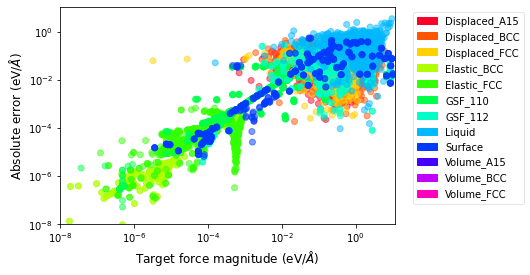

In [14]:
dataframe_tool.plot_agreement("Force", fitting_set="Training", mode="Distribution")

Better way to view images in Colab:

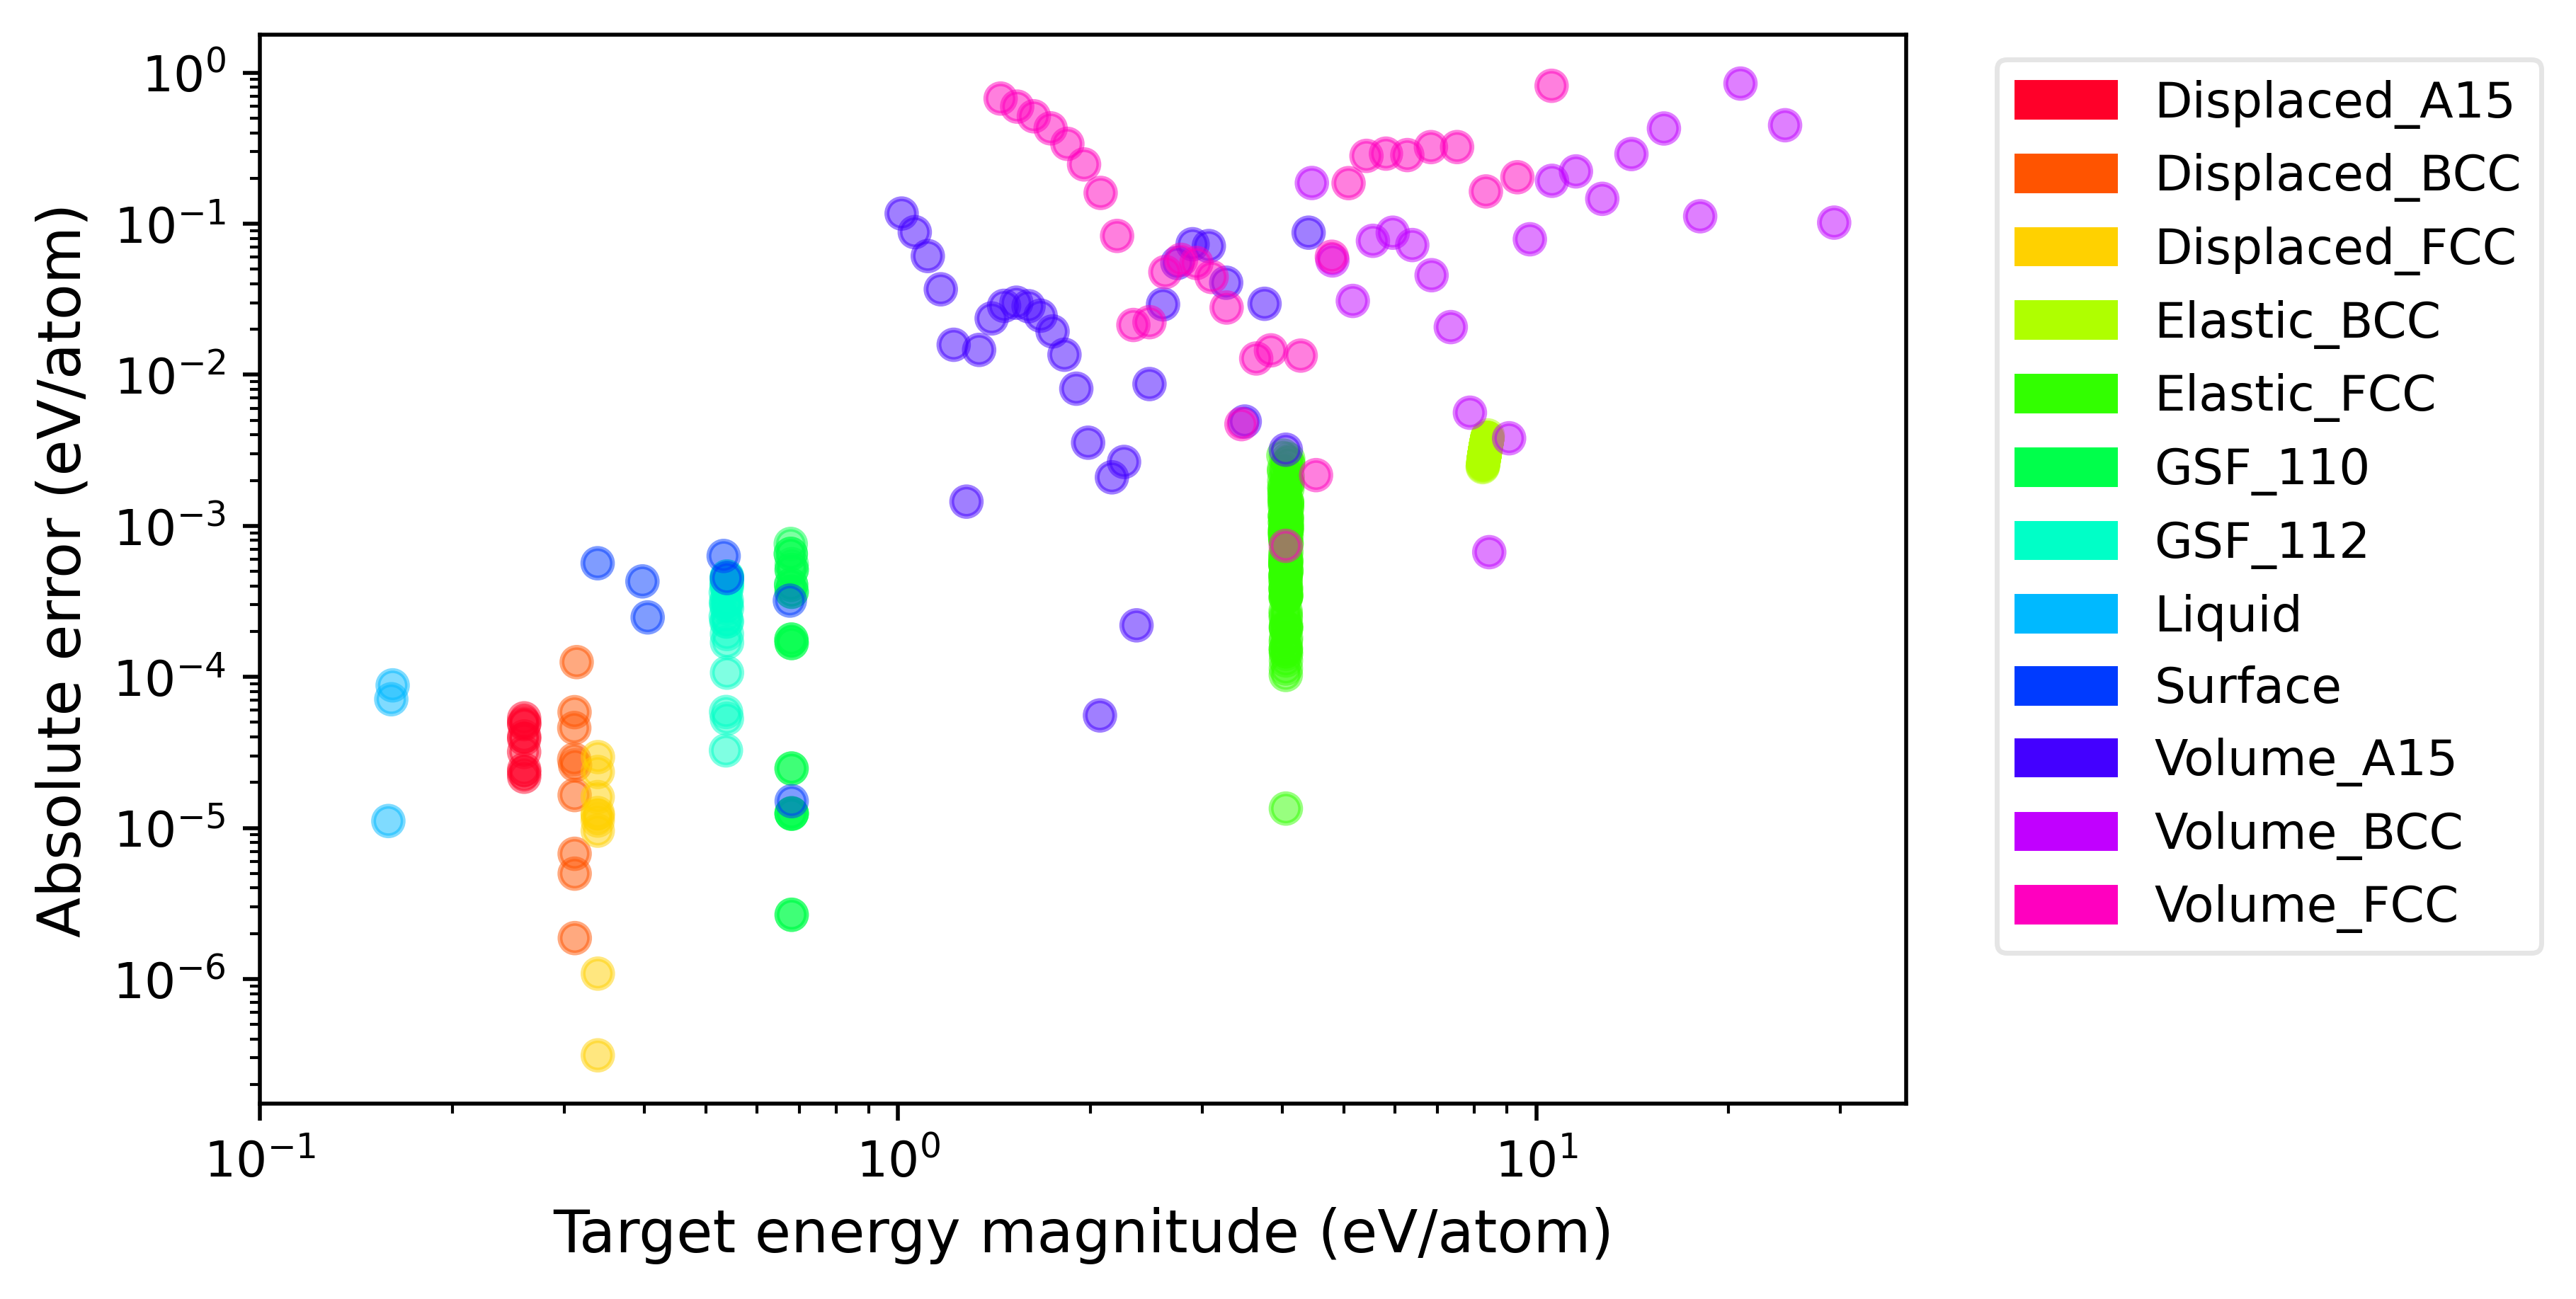

In [15]:
from IPython.display import Image
Image('energy_agreement.png')

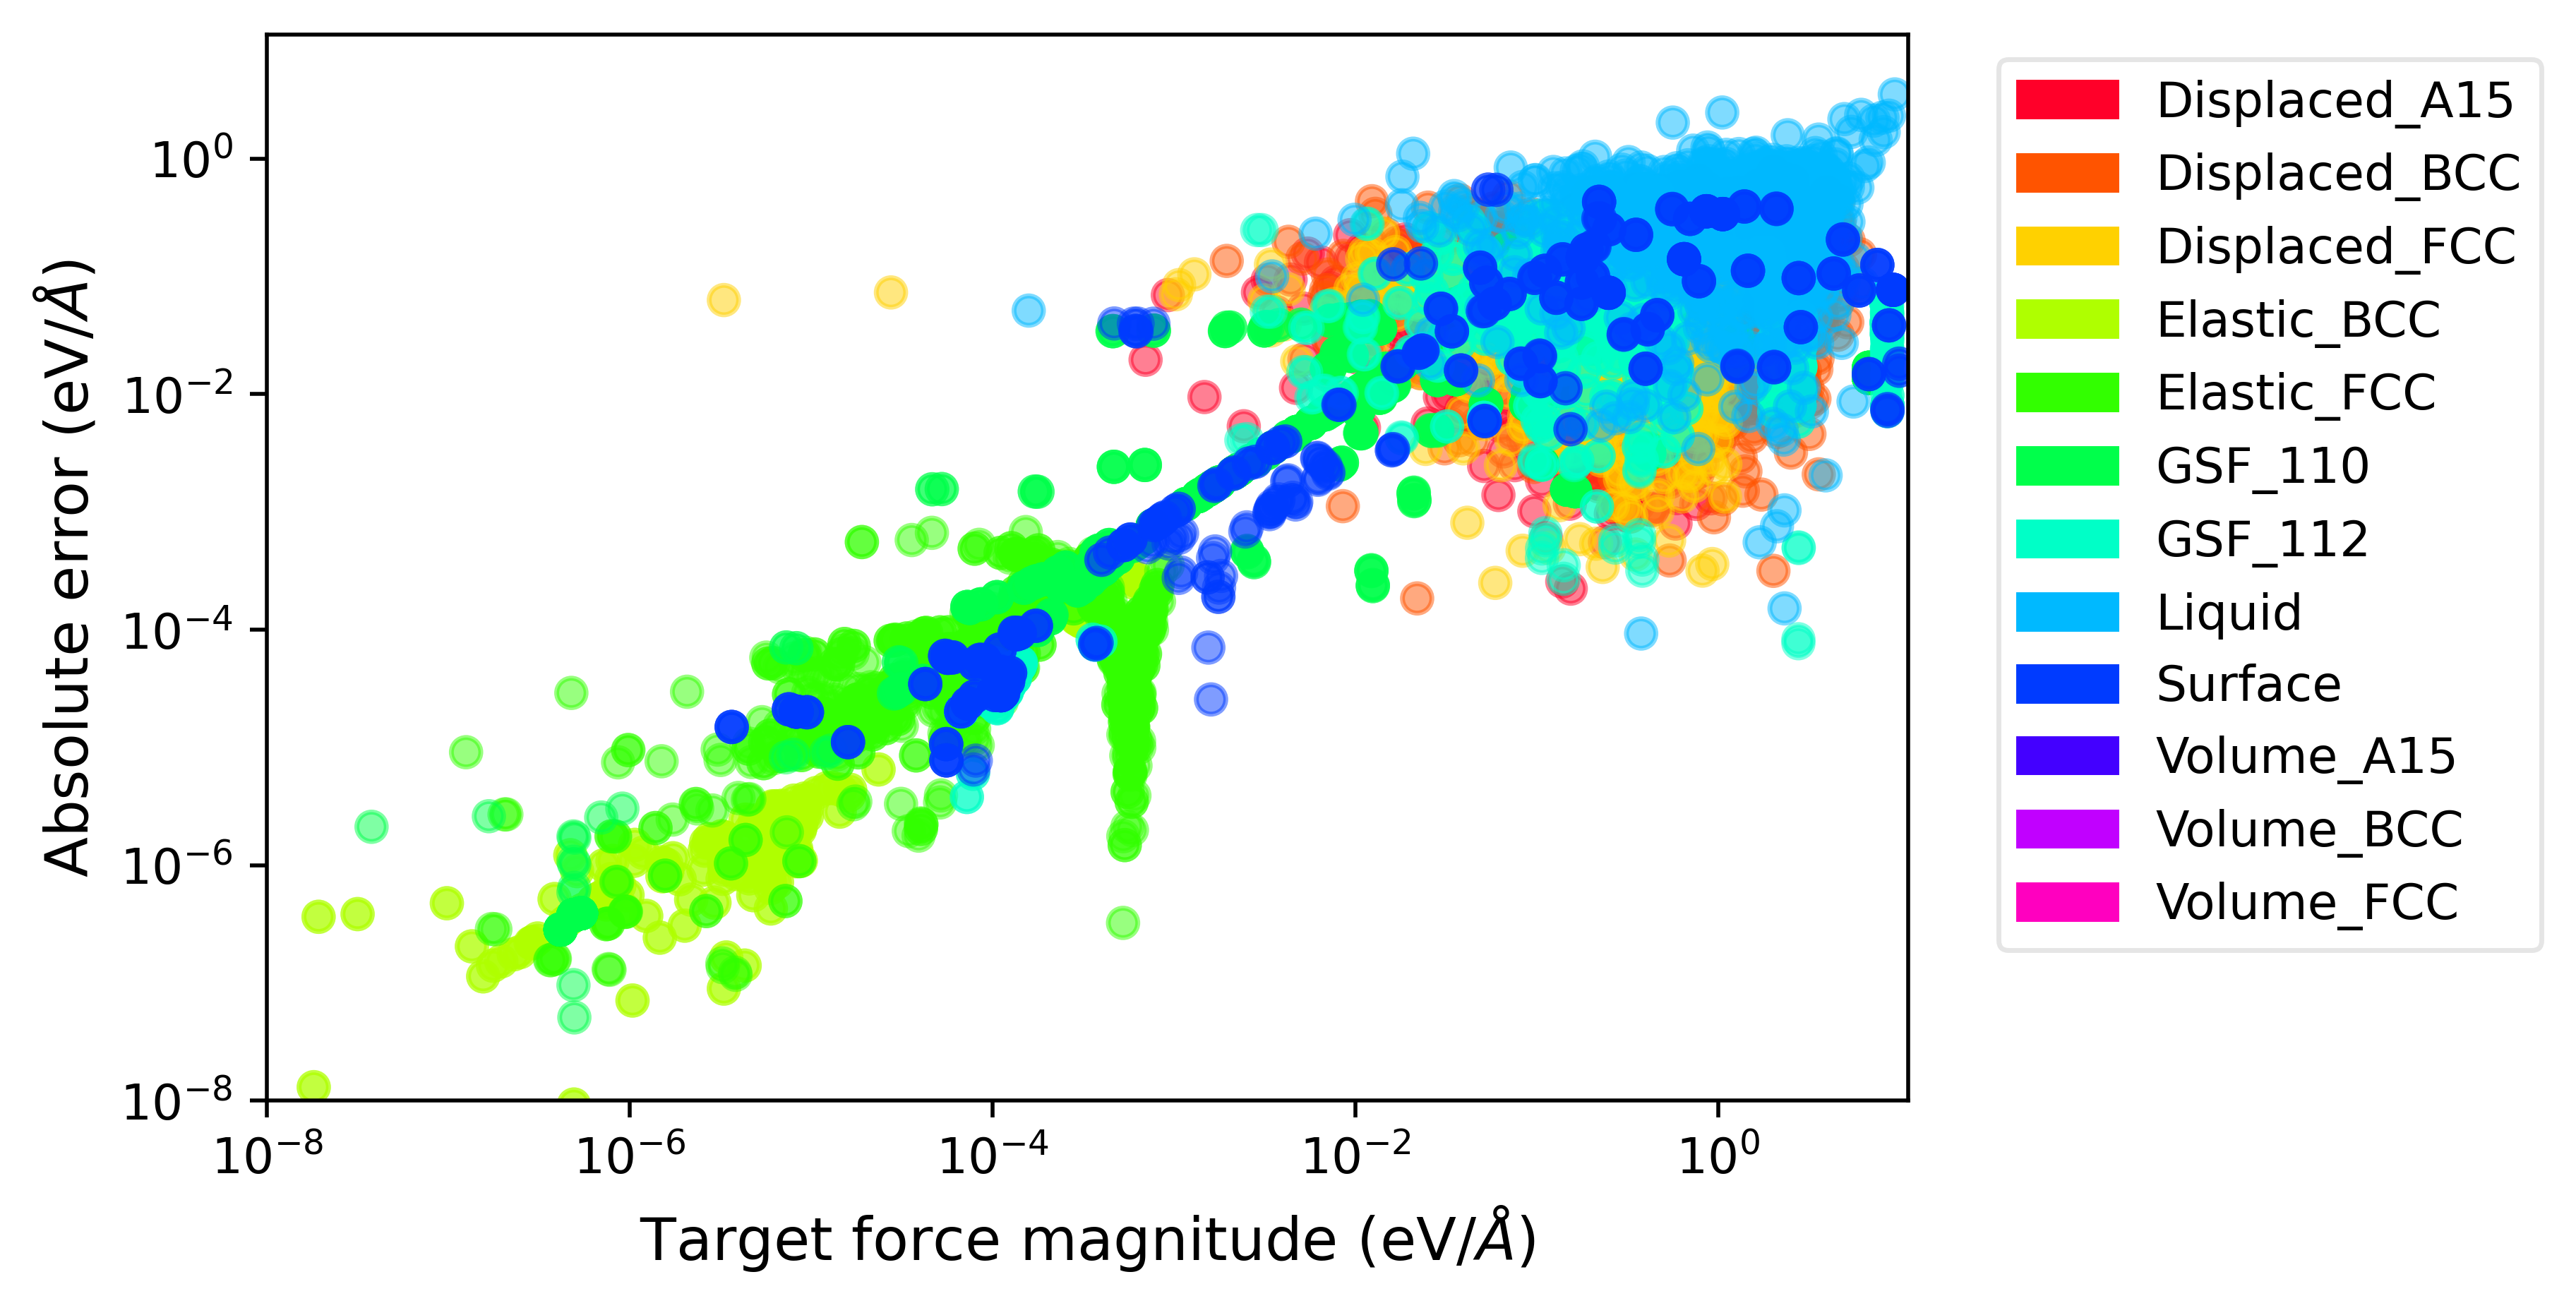

In [16]:
Image('force_agreement.png')

Aside from the dataframe, FitSNAP also made LAMMPS-ready potential files.

*   `Ta_pot.snapcoeff`
*   `Ta_pot.snapcoeff`



In [17]:
!ls

20May21_Standard      force_agreement.png   Ta_metrics.md
anl		      JSON		    Ta_pot.snapcoeff
compare_snapcoeff.py  log.lammps	    Ta_pot.snapparam
Descriptors.npy       README.md		    Test_Set_Example
energy_agreement.png  Ta-example.in	    Truth-Ref.npy
FitSNAP.df	      Ta-example-nodump.in  Weights.npy


We can use this to run MD or calculate errors on an entirely separate set, without performing fits.

### Using your potential to test errors on another set.



*   When training, we calculate errors on the training set and a validation set.
*   Often it is useful to calculate errors on entirely different set (a "test set") after training.
*   We can use FitSNAP+LAMMPS Python libraries for this.
*   We will load our fitted potential into LAMMPS and calculate energies/forces, then compare to the test set.



In [18]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014/

from fitsnap3lib.tools.lammps_tools import LammpsTools

# define pair style, input script, and test directory

pairstyle = """
            pair_style hybrid/overlay zbl 4.0 4.8 snap
            pair_coeff * * zbl 73 73
            pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta
            """
input_script = "Ta-example.in"
test_dir = "Test_Set_Example"

lmp_tools = LammpsTools(pairstyle, input_script, test_dir)
errors = lmp_tools.calculate() # creates dictionary of errors

print(f"{'Group':20} {'Energy MAE':3} {'Force MAE':3}")
for group in errors:
    print(f"{group:20} {errors[group]['mae_energy']:.3e} {errors[group]['mae_force']:.3e}")

/content/FitSNAP/examples/Ta_Linear_JCP2014
Using LAMMPSSNAP as FitSNAP calculator
Displaced_FCC_Test : Detected  9  fitting on  9  testing on  0
Elastic_FCC_Test : Detected  100  fitting on  100  testing on  0
'decorated_scrape_configs' took 194.17 ms on rank 0
Group                Energy MAE Force MAE
Displaced_FCC_Test   2.960e-02 5.741e-02
Elastic_FCC_Test     1.447e-02 9.642e-05


Visualize force agreement on this test set

In [ ]:
# plot truth vs. pred

The FitSNAP library does more than just process fitting data.

We can perform entire fits in library mode, offering a lot of flexibility.

### Perform fit in library mode

This is useful if you want to immediately screen for stability, for example when looping over fits. 

In [19]:
from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
pt = ParallelTools()
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# create a fitsnap object

from fitsnap3lib.fitsnap import FitSnap
snap = FitSnap()

# scrape configs, process configs, and perform the fit

snap.scrape_configs()
snap.process_configs()
snap.perform_fit()

#print(snap.solver.df)

Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  testing on  0
GSF_112 : Detected  22  fitting on  22  testing on  0
Liquid : Detected  3  fitting on  3  testing on  0
Surface : Detected  7  fitting on  7  testing on  0
Volume_A15 : Detected  30  fitting on  30  testing on  0
Volume_BCC : Detected  21  fitting on  21  testing on  0
Volume_FCC : Detected  31  fitting on  31  testing on  0
'decorated_scrape_configs' took 707.48 ms on rank 0
>>> Matrix of descriptors takes up  0.0277 % of the total memory: 13.6164 GB
'decorated_process_configs' took 3528.31 ms on rank 0
'decorated_perform_fit' took 532.72 ms on rank 0


This creates LAMMPS-ready potential files like running with the executable.

###Run MD in the same python script!

Use our LAMMPS-ready potential files immediately for MD.

In [20]:
# run MD

import lammps
lmp = lammps.lammps()

lammps_commands=\
"""
# initialize simulation

variable nsteps index 100
variable nrep equal 3
variable a equal 3.316
units           metal

# generate the box and atom positions using a BCC lattice

variable nx equal ${nrep}
variable ny equal ${nrep}
variable nz equal ${nrep}
boundary        p p p
lattice         bcc $a
region          box block 0 ${nx} 0 ${ny} 0 ${nz}
create_box      1 box
create_atoms    1 box
mass 1 180.88

# choose potential

pair_style hybrid/overlay zbl 4.0 4.8 snap
pair_coeff * * zbl 73 73
pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta

# setup output

thermo 100
thermo_style    custom step etotal temp pe
compute PE all pe

# set up NVE run

timestep 0.5e-3
neighbor 1.0 bin
neigh_modify once no every 1 delay 0 check yes

# run MD
velocity all create 300.0 4928459 loop geom
fix 1 all nve
run             ${nsteps}
"""

lmp.commands_string(lammps_commands)

# observe potential energy/stability over a 0.5 ps period

for i in range(10):
    pe = lmp.numpy.extract_compute("PE", 0, 0)
    print(pe)
    lmp.command("run 100")

-638.4597448877659
-638.7091594598376
-639.3317884482738
-638.8653515334704
-638.987385653348
-638.9483685194284
-639.0358014214416
-638.7717128027741
-639.1745103007072
-638.9794739892559


We also have access to the dataframe in Python:

### FitSNAP object stores dataframe as Python variable

In [21]:
snap.solver.df

0             1             2             3             4  \
0      1.0  1.008702e+02  2.776928e+00  6.376993e-01  8.194725e+00   
1      0.0 -1.667139e+00 -1.497190e-01  9.983620e-02  5.520839e-01   
2      0.0  3.524048e+00  6.441450e-01  2.701851e-01 -4.314339e-01   
3      0.0  1.716355e+00  1.046588e+00  1.284916e-01 -2.721603e+00   
4      0.0  4.509674e+00  8.230642e-01 -3.326674e-01 -6.081472e-01   
...    ...           ...           ...           ...           ...   
15208  0.0  7.157136e+06  3.139467e+05  1.026279e+05 -1.558680e+06   
15209  0.0  7.157136e+06  3.139467e+05  1.026279e+05 -1.558680e+06   
15210  0.0 -1.096496e-10  5.139824e-12  0.000000e+00 -2.741240e-11   
15211  0.0  0.000000e+00  5.139824e-12  0.000000e+00  0.000000e+00   
15212  0.0 -2.741240e-11 -1.713275e-12 -2.998231e-12  0.000000e+00   

                  5             6             7             8             9  \
0     -2.942508e+00  1.044658e+00  1.259830e+00  6.486961e+01 -2.665101e+00   
1     -2.841768e-01  5.570066e-02  1.006449e-01 -1.168041e+00 -4.461486e-01   
2     -5.799405e-01  3.565278e-01  2.537214e-01  3.587368e-01 -5.494900e-01   
3     -4.470627e-01  7.969225e-02  9.341716e-03  6.941766e+00  2.517323e-01   
4      1.805776e-01 -3.100630e-02  2.455265e-01  3.311481e-02  1.252996e+00   
...             ...           ...           ...           ...           ...   
15208 -4.163497e+05 -1.682987e+06 -1.015250e+06  6.602909e+06 -1.217066e+05   
15209 -4.163497e+05 -1.682987e+06 -1.015250e+06  6.602909e+06 -1.217066e+05   
15210 -6.853099e-12  0.000000e+00  0.000000e+00  0.000000e+00  4.283187e-13   
15211 -8.566374e-12  0.000000e+00  0.000000e+00  0.000000e+00 -4.711506e-12   
15212  0.000000e+00 -2.055930e-11 -6.853099e-12 -8.223719e-11 -2.569912e-12   

       ...            30        truths         preds       weights  \
0      ...  1.875399e+01 -1.659144e+01 -1.659348e+01  1.000000e+02   
1      ...  3.551769e+00  5.361133e-02  8.152259e-02  1.000000e+00   
2      ...  2.847111e+00  1.046982e-01  9.419053e-02  1.000000e+00   
3      ... -6.617734e-01 -1.378500e-02  1.026008e-01  1.000000e+00   
4      ... -2.661722e+00 -2.781446e-01 -4.077759e-01  1.000000e+00   
...    ...           ...           ...           ...           ...   
15208  ...  2.787561e+06 -6.529129e+05 -7.017254e+05  1.000000e-09   
15209  ...  2.787561e+06 -6.529129e+05 -7.017254e+05  1.000000e-09   
15210  ...  0.000000e+00  6.853099e-12 -1.551328e-12  1.000000e-09   
15211  ...  0.000000e+00  6.853099e-12  6.106081e-13  1.000000e-09   
15212  ...  1.370620e-11  6.853099e-12  6.588239e-12  1.000000e-09   

              Groups       Configs  Row_Type  Atom_I  Testing  Atom_Type  
0      Displaced_A15    A15_9.json    Energy       0    False          0  
1      Displaced_A15    A15_9.json     Force       0    False          1  
2      Displaced_A15    A15_9.json     Force       0    False          1  
3      Displaced_A15    A15_9.json     Force       0    False          1  
4      Displaced_A15    A15_9.json     Force       1    False          1  
...              ...           ...       ...     ...      ...        ...  
15208     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15209     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15210     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15211     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
15212     Volume_FCC  FCC_4.7.json    Stress       0    False          0  

[15213 rows x 40 columns]

***We can perform fits, run MD to check for stability, and still have access to the detailed errors in the dataframe, all in a single Python script.***

This provides a lot of flexibility/possibility for various training methods.

For example, one could loop over many fits while tweaking hyper-parameters.

### Loop over fits


*   This can be done to optimize hyperparameters for example.
*   Look at the `config` object to understand how we change settings for each fit. 
*   `config` contains information on the sections defined in the input script.
*   Examples:
*   `config.sections['BISPECTRUM']` contains bispectrum/descriptor settings.
*   `config.sections['GROUPS'].group_table['Liquid']['eweight']` contains energy weights associated with the `Liquid` group.
*   etc...
*   See more on Config files at https://docs.python.org/3/library/configparser.html

Define functions that we'll use for looping over fits:

In [22]:
import numpy as np

def change_descriptor_hyperparams(config):

    # twojmax, wj, and radelem are lists of chars

    config.sections['BISPECTRUM'].twojmax = ['6']
    config.sections['BISPECTRUM'].wj = ['1.0']
    config.sections['BISPECTRUM'].radelem = ['0.5']

    # rcutfac and rfac0 are doubles

    config.sections['BISPECTRUM'].rcutfac = 4.67637
    config.sections['BISPECTRUM'].rfac0 = 0.99363

    # after changing twojmax, need to generate_b_list to adjust all other variables

    config.sections['BISPECTRUM']._generate_b_list()

    return config

def change_weights(config, data):
    """
    Change fitting weights associated with each configuration of atoms.

    Attributes
    ----------

    config: FitSNAP Config object
        Holds input setting data

    data: FitSNAP data object
        Holds configuration data, positions, forces, weights, etc.
    """

    # need to find out how many groups there are

    #ngroups = len(config.sections['GROUPS'].group_table)
    #nweights = 0

    # loop through all group weights in the group_table and change the value

    for key in config.sections['GROUPS'].group_table:
        for subkey in config.sections['GROUPS'].group_table[key]:
            if ("weight" in subkey):
                #nweights += 1
                # change the weight
                config.sections['GROUPS'].group_table[key][subkey] = np.random.rand(1)[0]

    # loop through all configurations and set a new weight based on the group table

    for i, configuration in enumerate(data):
        group_name = configuration['Group']
        new_weight = config.sections['GROUPS'].group_table[group_name]
        for key in config.sections['GROUPS'].group_table[group_name]:
            if ("weight" in key):
                # set new weight 
                configuration[key] = config.sections['GROUPS'].group_table[group_name][key]

    return(config, data)

Use these functions to loop over fits while changing descriptors settings and/or weights:

In [23]:
from fitsnap3lib.tools.dataframe_tools import DataframeTools
from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
pt = ParallelTools()
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# create FitSNAP object
from fitsnap3lib.fitsnap import FitSnap
snap = FitSnap()

ngenerations = 2
for g in range(0,ngenerations):

    del snap
    del config
    del pt

    pt = ParallelTools()
    config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])
    snap = FitSnap()

    # tell ParallelTool not to create SharedArrays
    #pt.create_shared_bool = False
    # tell ParallelTools not to check for existing fitsnap objects
    #pt.check_fitsnap_exist = False
    # tell FitSNAP not to delete the data object after processing configs
    snap.delete_data = True
    snap.scraper.scrape_groups()
    snap.scraper.divvy_up_configs()
    snap.data = snap.scraper.scrape_configs()

    # change the bispectrum hyperparams

    config = change_descriptor_hyperparams(config)

    # change weight hyperparams

    (config, snap.data) = change_weights(config, snap.data)
    
    # process configs with new hyperparams
    # set indices to zero for populating new data array

    snap.calculator.shared_index=0
    snap.calculator.distributed_index=0 
    snap.process_configs()
     
    # perform a fit and gather dataframe with snap.solver.error_analysis()

    snap.solver.perform_fit()
    snap.solver.fit_gather()
    # need to empty errors before doing error analysis
    snap.solver.errors = []
    snap.solver.error_analysis()

    # now we have the dataframe, calculate errors with it

    df_tool = DataframeTools(snap.solver.df)
    mae_energy = df_tool.calc_error("Energy", "Training")
    mae_force = df_tool.calc_error("Force", "Training")

    print(f"---------- Generation {g} Force MAE: {mae_force} Energy MAE: {mae_energy}")

Using LAMMPSSNAP as FitSNAP calculator
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  testing on  0
GSF_112 : Detected  22  fitting on  22  testing on  0
Liquid : Detected  3  fitting on  3  testing on  0
Surface : Detected  7  fitting on  7  testing on  0
Volume_A15 : Detected  30  fitting on  30  testing on  0
Volume_BCC : Detected  21  fitting on  21  testing on  0
Volume_FCC : Detected  31  fitting on  31  testing on  0
>>> Matrix of descriptors takes up  0.0277 % of the total memory: 13.6164 GB
'decorated_process_configs' took 3423.42 ms on rank 0
---------- Generation 0 Force MAE: 0.26460475317506166 Energy MAE: 0.10640289257307087
Using LAMMPSSNAP as FitSNAP 

Can get creative here:

*   Run MD each iteration and train for stability, or some other property.
*   Optimize against some other external validation set, chosen by whatever means.
*   Any optimization approach can be wrapped around this framework.

*These capabilities demonstrate the flexibility of fitting we can have, but what about analyzing the data that we fit to?*

### Extracting per-atom SNAP descriptors

This is useful if you want to inspect the phase space of your descriptors, do PCA analysis, etc.

Make the following changes to the input script: 

*   `bikflag = 1` in `[BISPECTRUM]`
*   `bzeroflag = 1` in `[BISPECTRUM]` (required by `per_atom_energy = 1`)
*   `per_atom_energy = 1` in `[CALCULATOR]`

Calculate per-atom descriptors without performing a fit:

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014 
!python -m fitsnap3 Ta-example.in --overwrite --nofit

Now our dataframe contains per-atom descriptors. 


In [26]:
dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()
df

0             1             2             3             4  \
0      1.394503e+00 -5.575556e-03 -4.152476e-02  3.776393e-02 -9.472662e-02   
1      1.446173e+00 -6.016156e-03 -4.231198e-02  2.667406e-02 -9.210626e-02   
2      1.543011e+00  1.869240e-02 -3.400672e-02  1.095122e-01 -1.168388e-01   
3      1.547402e+00  1.751158e-02 -3.437167e-02  1.097481e-01 -1.157124e-01   
4      1.576101e+00  1.463718e-02 -3.563344e-02  1.083240e-01 -1.125795e-01   
...             ...           ...           ...           ...           ...   
19069  7.157136e+06  3.139467e+05  1.026279e+05 -1.558680e+06 -4.163497e+05   
19070  7.157136e+06  3.139467e+05  1.026279e+05 -1.558680e+06 -4.163497e+05   
19071 -1.096496e-10  5.139824e-12  0.000000e+00 -2.741240e-11 -6.853099e-12   
19072  0.000000e+00  5.139824e-12  0.000000e+00  0.000000e+00 -8.566374e-12   
19073 -2.741240e-11 -1.713275e-12 -2.998231e-12  0.000000e+00  0.000000e+00   

                  5             6             7             8             9  \
0     -3.578573e-02 -5.926950e-02  9.826018e-01 -1.184815e-01  8.329407e-02   
1     -3.750786e-02 -6.050598e-02  1.011099e+00 -1.186092e-01  7.483574e-02   
2     -2.539166e-02 -5.670590e-02  9.063065e-01 -1.194959e-01  9.475957e-02   
3     -2.608424e-02 -5.690227e-02  8.973633e-01 -1.195257e-01  9.179622e-02   
4     -2.866494e-02 -5.778653e-02  8.907764e-01 -1.187584e-01  8.353084e-02   
...             ...           ...           ...           ...           ...   
19069 -1.682987e+06 -1.015250e+06  6.602909e+06 -1.217066e+05  1.239266e+06   
19070 -1.682987e+06 -1.015250e+06  6.602909e+06 -1.217066e+05  1.239266e+06   
19071  0.000000e+00  0.000000e+00  0.000000e+00  4.283187e-13  0.000000e+00   
19072  0.000000e+00  0.000000e+00  0.000000e+00 -4.711506e-12  0.000000e+00   
19073 -2.055930e-11 -6.853099e-12 -8.223719e-11 -2.569912e-12  3.426549e-11   

       ...            28            29        truths       weights  \
0      ...  9.724227e-02  2.771061e-01 -1.659144e+01  1.000000e+02   
1      ...  1.045078e-01  2.944053e-01  0.000000e+00  0.000000e+00   
2      ...  6.877058e-02  1.448796e-01  0.000000e+00  0.000000e+00   
3      ...  7.185572e-02  1.447689e-01  0.000000e+00  0.000000e+00   
4      ...  8.705536e-02  1.479679e-01  0.000000e+00  0.000000e+00   
...    ...           ...           ...           ...           ...   
19069  ...  6.884283e+05  2.787561e+06 -6.529129e+05  1.000000e-09   
19070  ...  6.884283e+05  2.787561e+06 -6.529129e+05  1.000000e-09   
19071  ...  1.370620e-11  0.000000e+00  6.853099e-12  1.000000e-09   
19072  ... -1.370620e-11  0.000000e+00  6.853099e-12  1.000000e-09   
19073  ... -3.426549e-12  1.370620e-11  6.853099e-12  1.000000e-09   

              Groups       Configs  Row_Type  Atom_I  Testing  Atom_Type  
0      Displaced_A15    A15_9.json    Energy       0    False          1  
1      Displaced_A15    A15_9.json    Energy       1    False          1  
2      Displaced_A15    A15_9.json    Energy       2    False          1  
3      Displaced_A15    A15_9.json    Energy       3    False          1  
4      Displaced_A15    A15_9.json    Energy       4    False          1  
...              ...           ...       ...     ...      ...        ...  
19069     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
19070     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
19071     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
19072     Volume_FCC  FCC_4.7.json    Stress       0    False          0  
19073     Volume_FCC  FCC_4.7.json    Stress       0    False          0  

[19074 rows x 38 columns]

We can use this to visualize how similar certain groups/configurations are to each other. 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


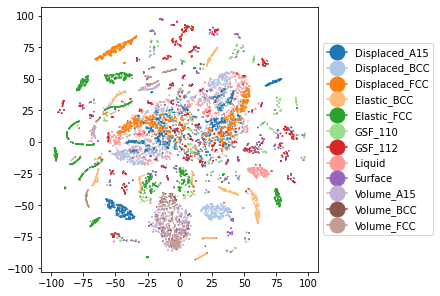

In [28]:
from fitsnap3lib.tools.dataframe_tools import DataframeTools
df_tool = DataframeTools("FitSNAP.df")
df = df_tool.read_dataframe()
df_tool.plot_tsne(num_descriptors = 30, point_size=0.2)

This can take a few min to run... Output looks like this:
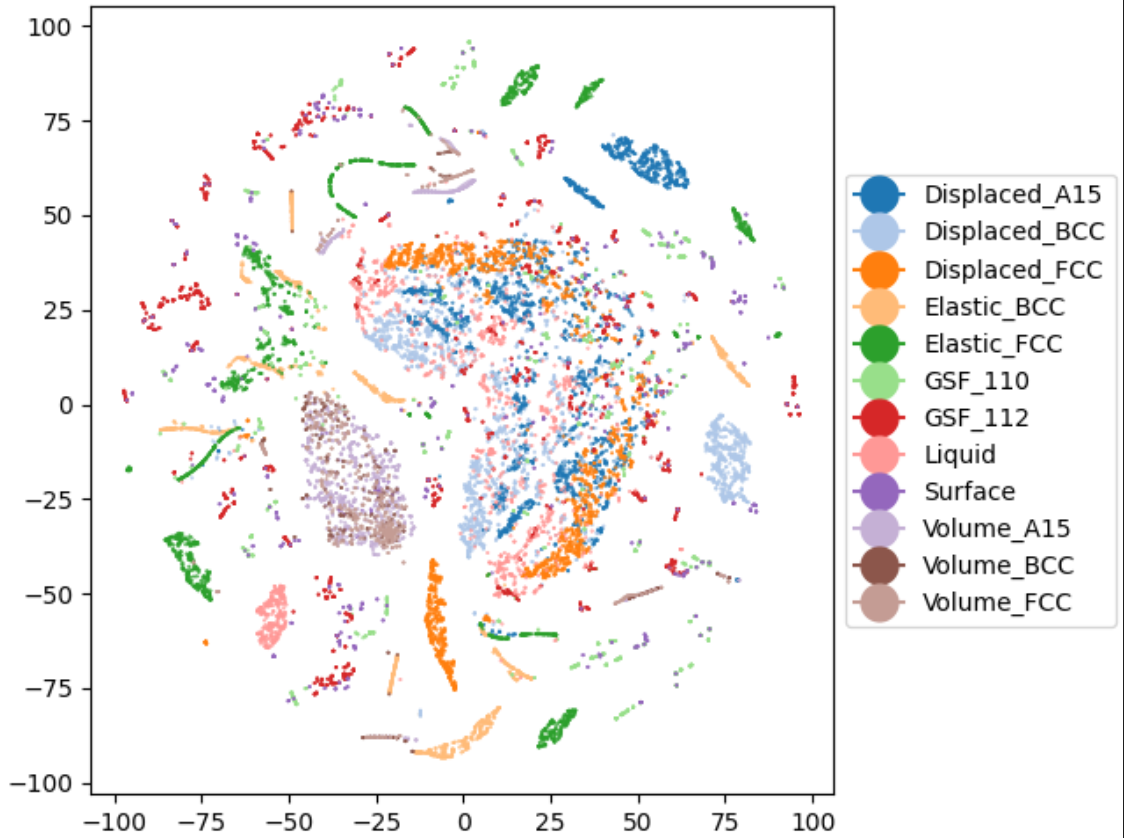

We also need per-atom descriptors for NN potentials, which we will do next.

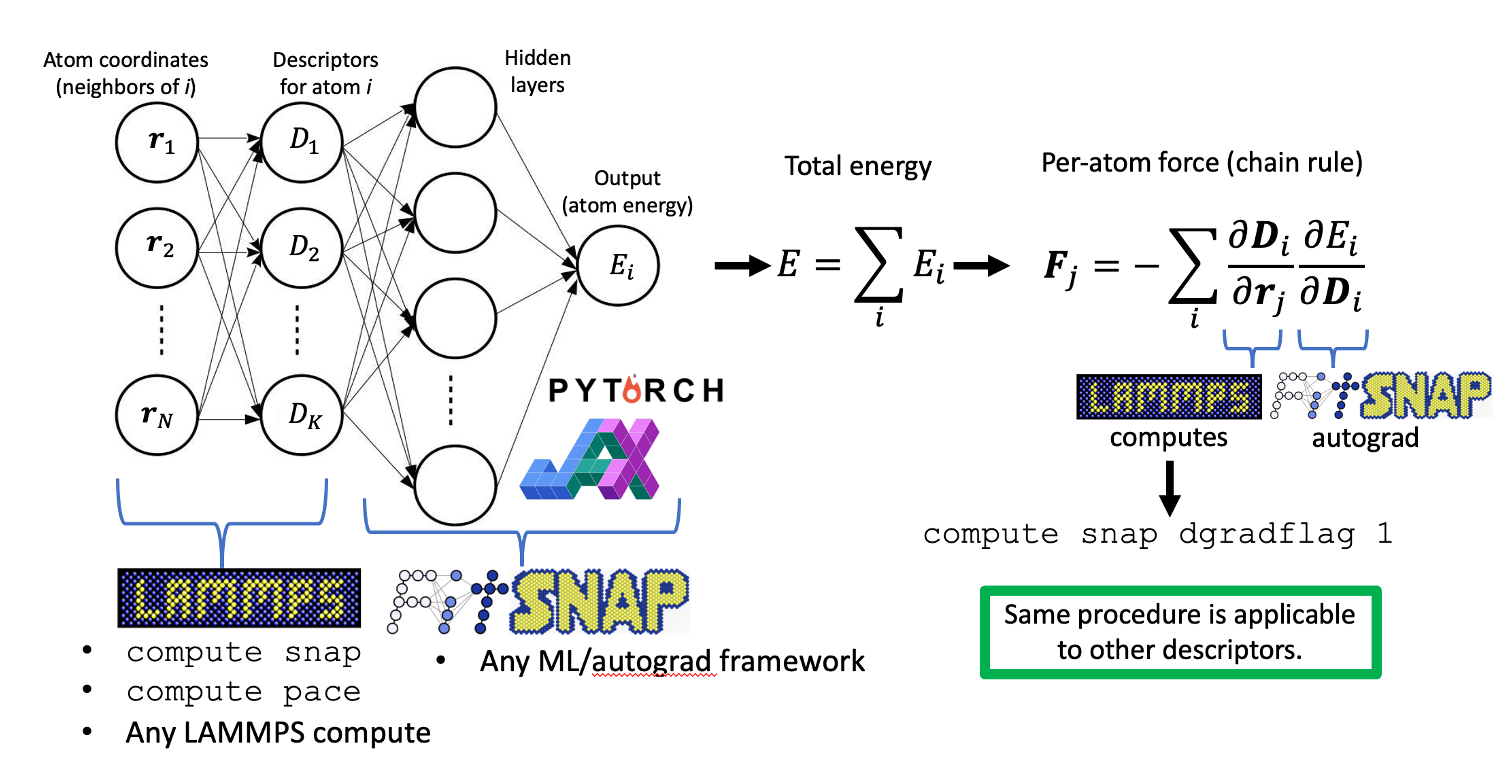

# Fit NN-SNAP for tantalum

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN
!python -m fitsnap3 Ta-example.in --overwrite

Look at loss vs. epochs

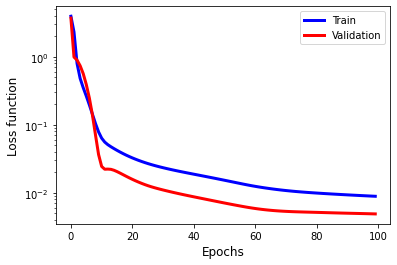

In [28]:
from matplotlib import pyplot as plt
import numpy as np

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

dat = np.loadtxt("loss_vs_epochs.dat")

plt.plot(dat[:,0], dat[:,1], 'b-', linewidth=3)
plt.plot(dat[:,0], dat[:,2], 'r-', linewidth=3)
plt.xlabel("Epochs")
plt.ylabel(r'Loss function')
plt.yscale('log')
plt.legend(["Train", "Validation"])
plt.show("error_vs_epochs.png")

Look at training and validation errors for forces and energies

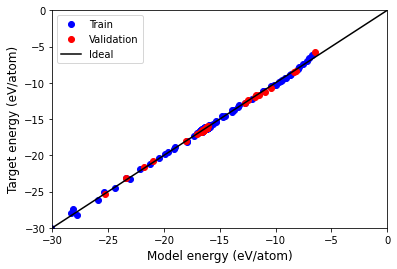

In [29]:
dat = np.loadtxt("energy_comparison.dat")
dat_val = np.loadtxt("energy_comparison_val.dat")

lims = [-30, 0]
plt.plot(dat[:,0], dat[:,1], 'bo')
plt.plot(dat_val[:,0], dat_val[:,1], 'ro')
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model energy (eV/atom)")
plt.ylabel("Target energy (eV/atom)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show()

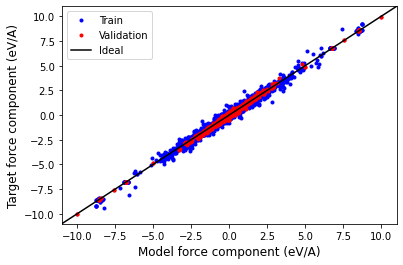

In [30]:
dat = np.loadtxt("force_comparison.dat")
dat_val = np.loadtxt("force_comparison_val.dat")

lims = [-11, 11]
plt.plot(dat[:,0], dat[:,1], 'bo', markersize=3)
plt.plot(dat_val[:,0], dat_val[:,1], 'ro', markersize=3)
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model force component (eV/A)")
plt.ylabel("Target force component (eV/A)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show()

**Store linear and NN MAEs as python variables, compare them here.**

### Run MD with Ta NN-SNAP

In [31]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN/MD
!/content/lammps/build/lmp < in.run

/content/FitSNAP/examples/Ta_PyTorch_NN/MD
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 3.316 3.316 3.316
Created orthogonal box = (0 0 0) to (13.264 13.264 13.264)
  1 by 1 by 1 MPI processor grid
Created 128 atoms
  using lattice units in orthogonal box = (0 0 0) to (13.264 13.264 13.264)
  create_atoms CPU = 0.000 seconds
Loading python model complete.
SNAP keyword rcutfac 4.67637 
SNAP keyword twojmax 6 
SNAP keyword nelems 1 
SNAP keyword elems Ta 
SNAP keyword radelems 0.5 
SNAP keyword welems 1 
SNAP keyword rfac0 0.99363 
SNAP keyword rmin0 0 
SNAP keyword bzeroflag 1 
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 5.8
  ghost atom cutoff = 5.8
  binsize = 2.9, bins = 5 5 5
  2 neighbor lists, perpetual/occasional/extra = 2 0 0
  (1) pair zbl, per

# Multi-element NNs

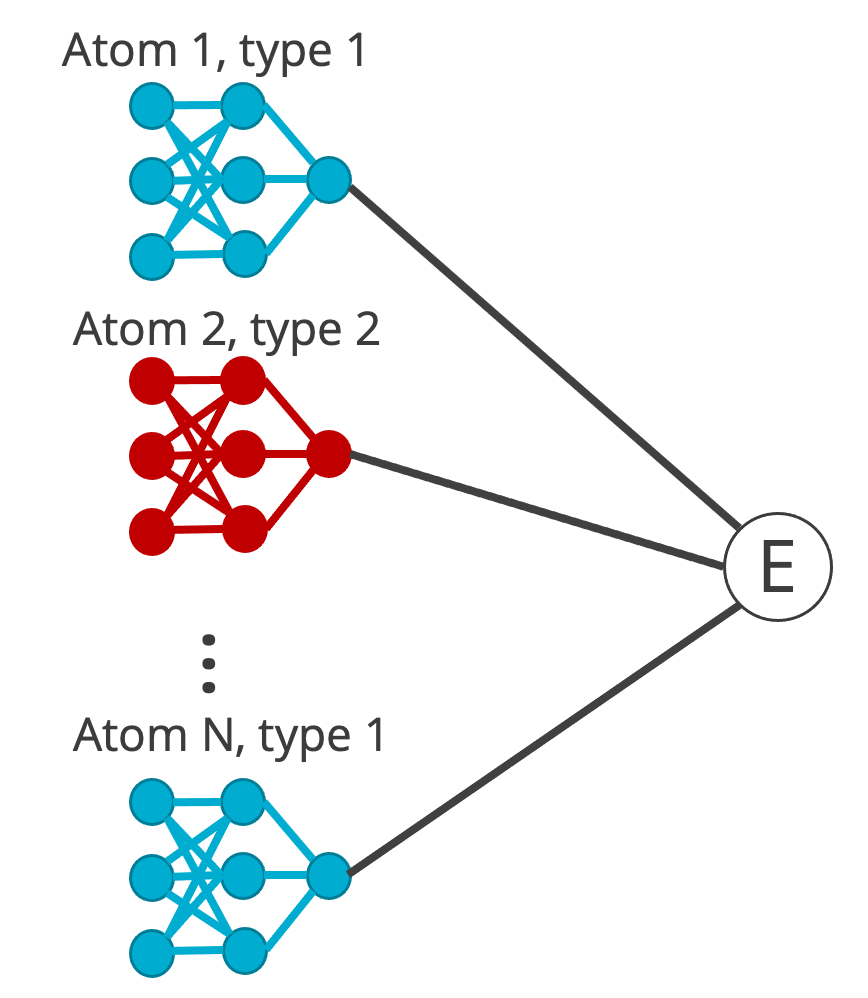

Example: Fit to 5200 configurations in the WBe set.

Time to fit (on Colab): ~10 min

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN
!mpirun --allow-run-as-root -np 4 python -m fitsnap3 WBe-example.in --overwrite

Look at loss vs. epochs:

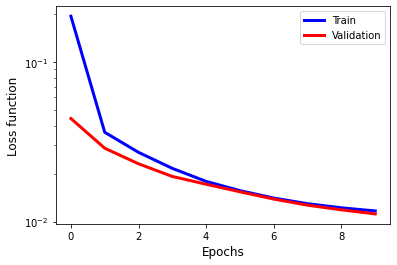

In [34]:
dat = np.loadtxt("loss_vs_epochs.dat")

plt.plot(dat[:,0], dat[:,1], 'b-', linewidth=3)
plt.plot(dat[:,0], dat[:,2], 'r-', linewidth=3)
plt.xlabel("Epochs")
plt.ylabel(r'Loss function')
plt.yscale('log')
plt.legend(["Train", "Validation"])
plt.show("error_vs_epochs.png")

Convergence looks different than for the Ta case... why?

We fit to 5000+ configurations here, while the Ta example only has ~300 configurations. With a batch size of 4, a lot of optimization is happening in a single epoch. We therefore need fewer epochs to converge.

Visualize training and validation errors for energies:

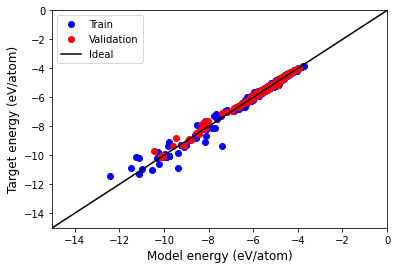

In [36]:
dat = np.loadtxt("energy_comparison.dat")
dat_val = np.loadtxt("energy_comparison_val.dat")

lims = [-15, 0]
plt.plot(dat[:,0], dat[:,1], 'bo')
plt.plot(dat_val[:,0], dat_val[:,1], 'ro')
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model energy (eV/atom)")
plt.ylabel("Target energy (eV/atom)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show()

Visualize training and validation errors for forces:

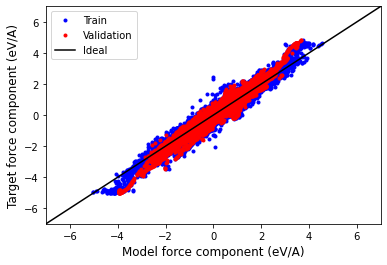

In [38]:
dat = np.loadtxt("force_comparison.dat")
dat_val = np.loadtxt("force_comparison_val.dat")

lims = [-7, 7]
plt.plot(dat[:,0], dat[:,1], 'bo', markersize=3)
plt.plot(dat_val[:,0], dat_val[:,1], 'ro', markersize=3)
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model force component (eV/A)")
plt.ylabel("Target force component (eV/A)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show()

We also created a `FitTorch_pytorch.pt` file which is used by LAMMPS for MD.

### Run MD with WBe NN-SNAP

In [39]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN/MD
!/content/lammps/build/lmp < in.run

/content/FitSNAP/examples/WBe_PyTorch_NN/MD
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 3.1803 3.1803 3.1803
Created orthogonal box = (0 0 0) to (9.5409 9.5409 9.5409)
  1 by 1 by 1 MPI processor grid
Created 54 atoms
  using lattice units in orthogonal box = (0 0 0) to (9.5409 9.5409 9.5409)
  create_atoms CPU = 0.004 seconds
Setting atom values ...
  0 settings made for type/fraction
54 atoms in group tungsten
0 atoms in group beryllium
Loading python model complete.
SNAP keyword rcutfac 1.0 
SNAP keyword twojmax 6 
SNAP keyword nelems 2 
SNAP keyword elems W Be 
SNAP keyword radelems 0.5 0.417932464 
SNAP keyword welems 1.0 0.9590493408 
SNAP keyword rfac0 0.99363 
SNAP keyword rmin0 0 
SNAP keyword bzeroflag 1 
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance c

# NN training computational benchmarks

Training computation scales roughly as `num_atoms*num_neighs`.

Rough benchmarks for CPU training:

*   Ta example - 363 configs, ~12 atoms per config, batch_size=4: 0.3 s/epoch
*   WBe example - ~5000 configs, ~24 atoms per config, batch_size=4: 13 s/epoch
*   W entropy dataset - 10k configs, ~30 atoms per config, batch_size=4: 22 s/epoch
*   Svetoslav set - 42k configs, ~40 atoms per config, batch_size=4, cutoff = 15 A: 5 min/epoch

### GPU acceleration

If you have a GPU with CUDA and PyTorch installed, the NN training will automatically use it. 

There is one way to observe GPU speedups: give it a lot of operations to parallelize over. 

This is achieved with:

1.   Large batch size
2.   Large model size

Our examples used neither, but we are free to experiment here. 





# Advanced/Development Topics: Custom Calculator

We can extract pure LAMMPS positions and neighlist

This allows one to define their own descriptor and Solver using these positions.

For this example we will use Bessel function descriptors located in `fitsnap3lib/lib/neural_networks/descriptors/bessel.py`

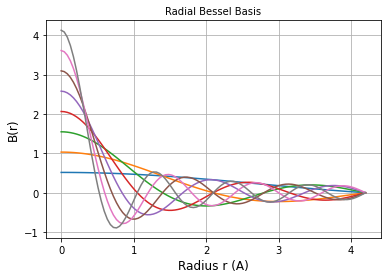

In [42]:
def calculate_bessel(r, n, rc):
    """
    Calculate radial bessel functions for all pairs

    Attributes
    ----------

    r: np array
        Pairwise distance array with size (number_neigh, 1)

    n: np array
        Integer in float form representing Bessel radial parameter n

    Returns
    -------

    rbf: np array
        Radial Bessel function calculation for base n, has size (number_neigh, 1)
    """

    # calculate Bessel

    pi = np.pi
    rbf = np.divide(np.sqrt(2./rc)*np.sin(((n*pi)/rc)*r), r)     

    return rbf

# Bessel parameters

rc = 4.2
num_rbf = 8

r = np.linspace(0.0001,rc,100)
h = r[1]-r[0]
r = np.expand_dims(r, axis=1)
basis = np.concatenate([calculate_bessel(r, n, rc) for n in range(1,num_rbf+1)], axis=1)

fig, ax = plt.subplots()
for i in range(0,num_rbf):
    ax.plot(r, basis[:,i])

ax.set(xlabel='Radius r (A)', ylabel='B(r)',
       title='Radial Bessel Basis')
ax.grid()

fig.show()

This opens up many possibilities when combined with differentiable programming.

# End-to-End Differentiable Potential Optimization

***End-to-end differentiable models have only differentiable parameters to enable joint optimization from input to output.***

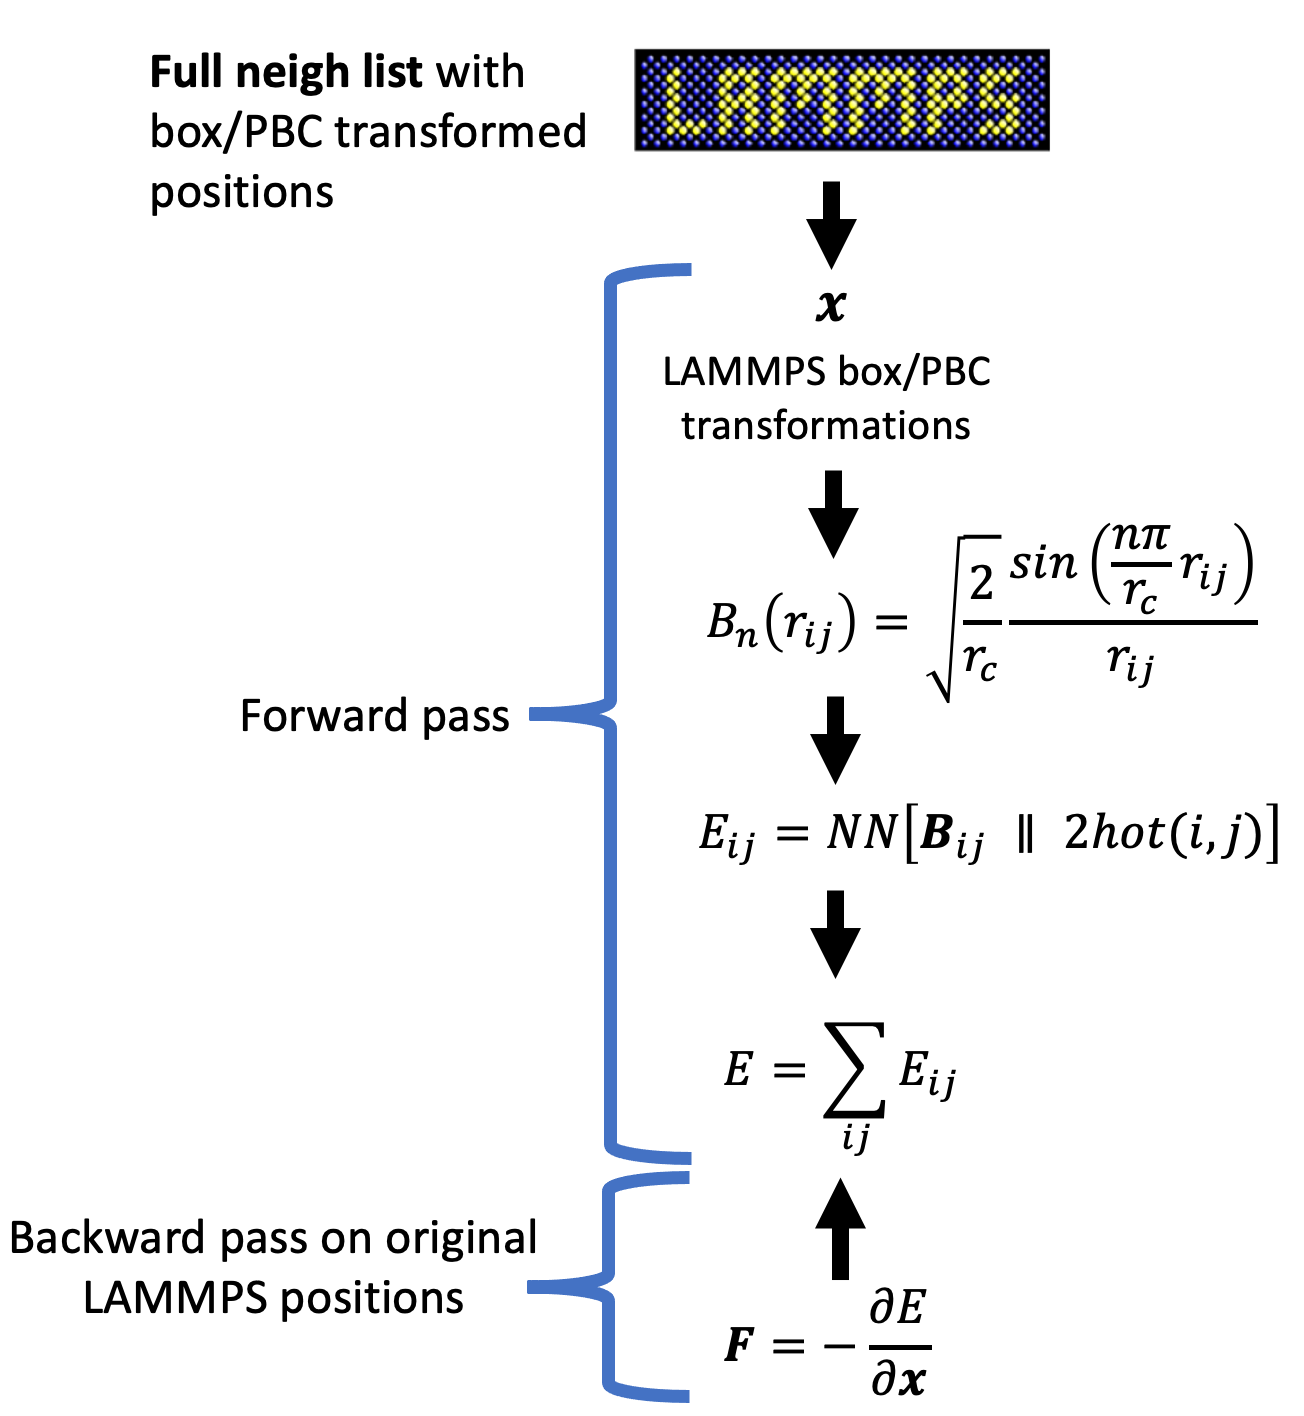


Pros: 

*   "Descriptor" hyperparams get optimized as a part of the computational graph.
*   Less RAM.

Cons:

*   Slower training, need to evaluate descriptors every epoch (might be worth it considering no descriptor hyperparameters).

Here we show an example with a custom pairwise network I coded last week (show structure).

Advantages:

*   General atom-type description allows extension to many atom types.
*   More granularity in interactions (pairwise vs. per-atom) might allow for more flexibility and increased accuracy.



In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/
from fitsnap3lib.tools.test_tools import TestTools
from fitsnap3lib.io.input import Config
input_script = "Ta-example.in"
test_tool = TestTools(input_script)
test_tool.finite_difference(group="Displaced_BCC")

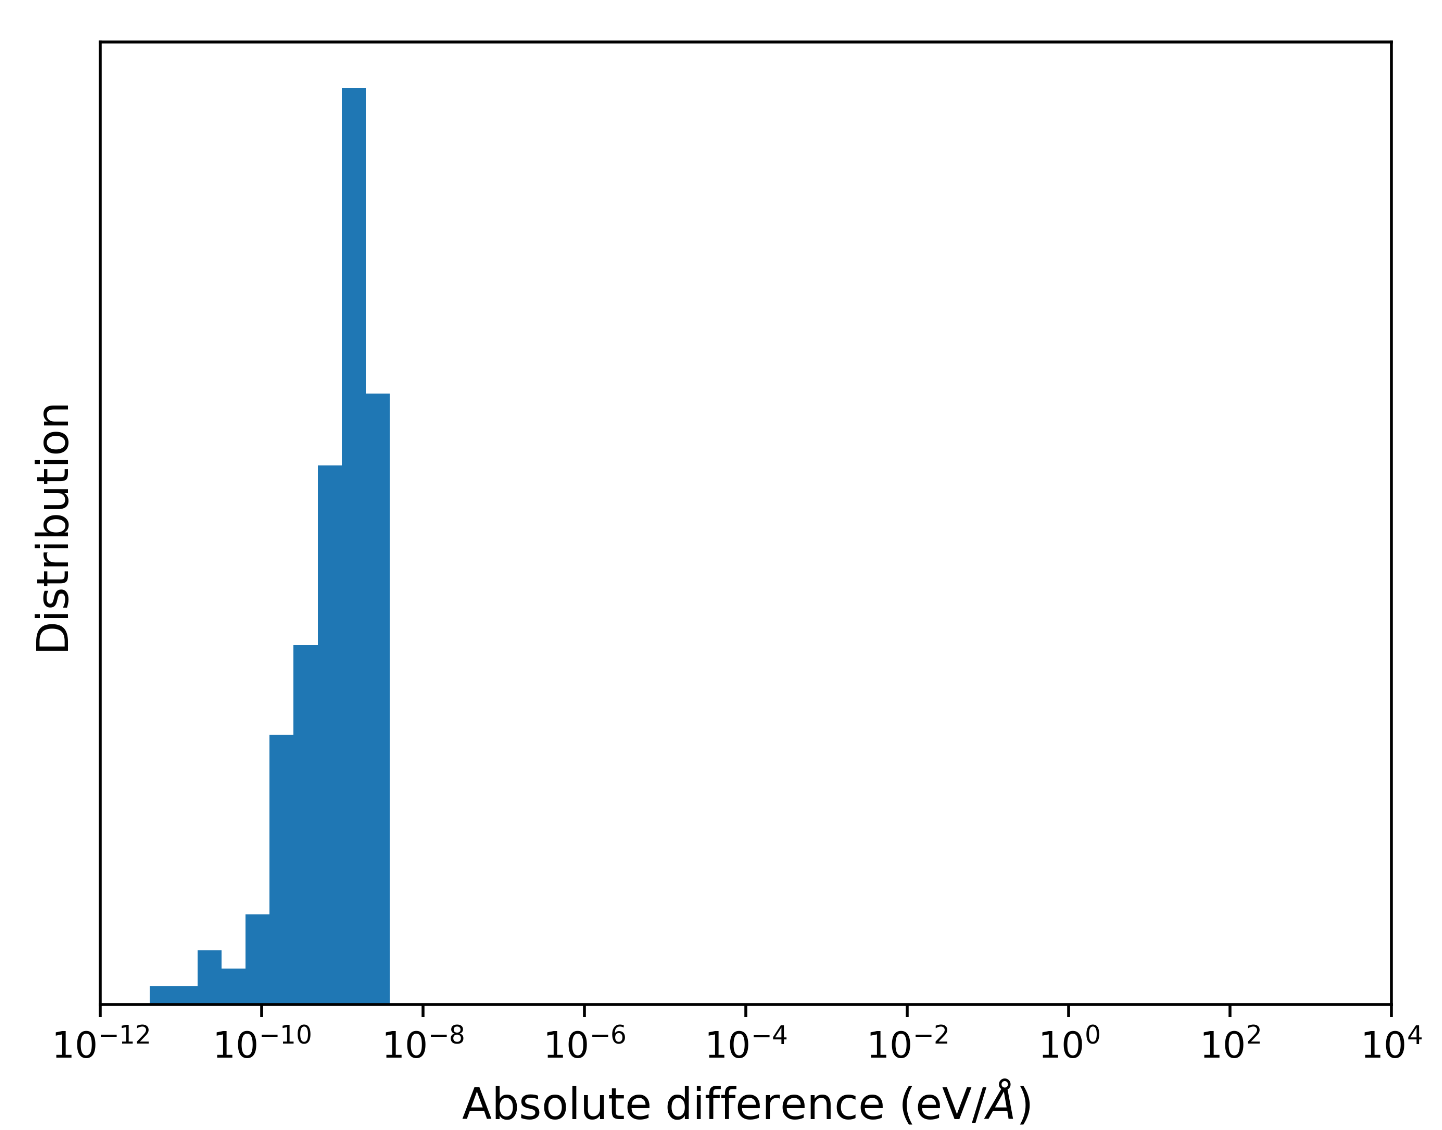

Fit the pairwise network.

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/
!python -m fitsnap3 Ta-example.in --overwrite

The force agreement is less accurate, because it's only a 2-body radial potential.

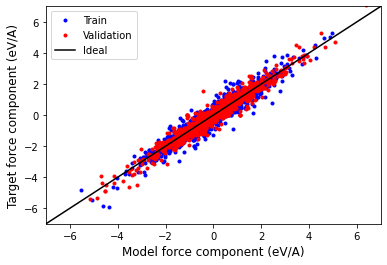

In [50]:
dat = np.loadtxt("force_comparison.dat")
dat_val = np.loadtxt("force_comparison_val.dat")

lims = [-7, 7]
plt.plot(dat[:,0], dat[:,1], 'bo', markersize=3)
plt.plot(dat_val[:,0], dat_val[:,1], 'ro', markersize=3)
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model force component (eV/A)")
plt.ylabel("Target force component (eV/A)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show()

The custom networks leave a lot of flexibility and room for creativitiy; they have more granularity in learning different types of interactions. For example this is in development now:

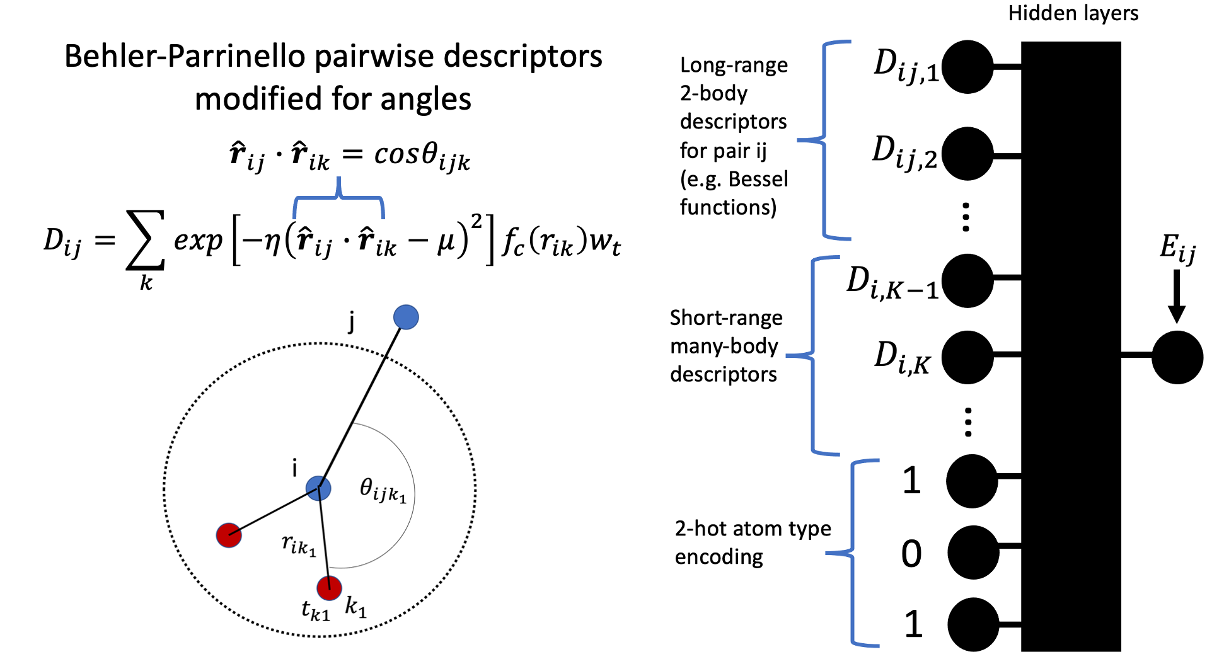

This will capture not only bond order, but *directional* bond order (e.g. water molecule). This may be more accurate for modeling reactions and charged systems.  

*   General handling of types without poor scaling with number of types.
*   Environment-dependent and/or reactive.

